In [1]:
#Importing the basic librarires

import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]
import warnings 
warnings.filterwarnings('ignore')

In [2]:
#importing the dataset
data = pd.read_csv('/Users/mithilapapishetty/Downloads/Walmart_data.csv') 

#EXPLORING THE DATASET
#First 5 records of dataset
print(data.head())

#check for datatypes and missing values count of each column
print(data.info())

#number of unique rows in each feature
data.nunique().sort_values()

# Summary statistics for numerical columns
print(data.describe())


   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   i

In [3]:
#PREPROCESSING

#Removal of any Duplicate rows 

counter = 0
rs,cs = data.shape
data.drop_duplicates(inplace=True)
if data.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}'
         )

#Date to datetime reframing

#date 
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data['day'] = data['Date'].dt.day
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year

#checking for null values

nvc = pd.DataFrame(data.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/data.shape[0],3)*100
print(nvc)



Inference: The dataset doesn't have any duplicates
              Total Null Values  Percentage
Store                         0         0.0
Date                          0         0.0
Weekly_Sales                  0         0.0
Holiday_Flag                  0         0.0
Temperature                   0         0.0
Fuel_Price                    0         0.0
CPI                           0         0.0
Unemployment                  0         0.0
day                           0         0.0
month                         0         0.0
year                          0         0.0


In [4]:
#check for outliers 

# Identify numerical columns
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Calculate IQR for each numerical column
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)  # 25th percentile
    Q3 = data[col].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile Range

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]

    print(f"Column: {col}")
    print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    print(f"Number of Outliers: {outliers.shape[0]}")
    print()




Column: Store
Lower Bound: -21.0, Upper Bound: 67.0
Number of Outliers: 0

Column: Weekly_Sales
Lower Bound: -746862.7275, Upper Bound: 2720371.4924999997
Number of Outliers: 34

Column: Holiday_Flag
Lower Bound: 0.0, Upper Bound: 0.0
Number of Outliers: 450

Column: Temperature
Lower Bound: 6.240000000000002, Upper Bound: 116.16
Number of Outliers: 3

Column: Fuel_Price
Lower Bound: 1.7299999999999998, Upper Bound: 4.938
Number of Outliers: 0

Column: CPI
Lower Bound: 10.222559825000019, Upper Bound: 334.255733625
Number of Outliers: 0

Column: Unemployment
Lower Bound: 4.2945, Upper Bound: 11.218499999999999
Number of Outliers: 481



In [5]:
# Removing outliers using IQR method
data_cleaned = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

data_cleaned.info()

#after removing the outliers, the data has 5954 records


<class 'pandas.core.frame.DataFrame'>
Index: 5954 entries, 0 to 6434
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         5954 non-null   int64         
 1   Date          5954 non-null   datetime64[ns]
 2   Weekly_Sales  5954 non-null   float64       
 3   Holiday_Flag  5954 non-null   int64         
 4   Temperature   5954 non-null   float64       
 5   Fuel_Price    5954 non-null   float64       
 6   CPI           5954 non-null   float64       
 7   Unemployment  5954 non-null   float64       
 8   day           5954 non-null   int32         
 9   month         5954 non-null   int32         
 10  year          5954 non-null   int32         
dtypes: datetime64[ns](1), float64(5), int32(3), int64(2)
memory usage: 488.4 KB


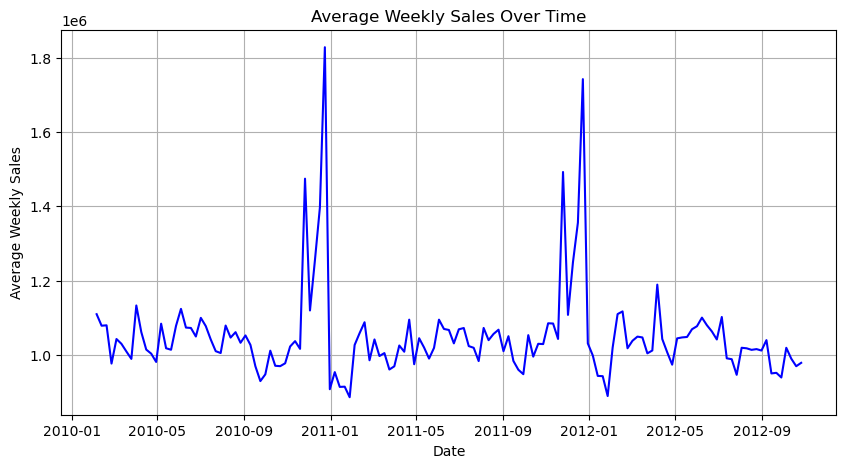

In [6]:
#sales trends over time 

# Aggregate data by Date for averages
aggregated_data = data_cleaned.groupby('Date').mean()
plt.figure(figsize=(10, 5))
plt.plot(aggregated_data.index, aggregated_data['Weekly_Sales'], color='blue')
plt.title('Average Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Average Weekly Sales')
plt.grid(True)
plt.show()



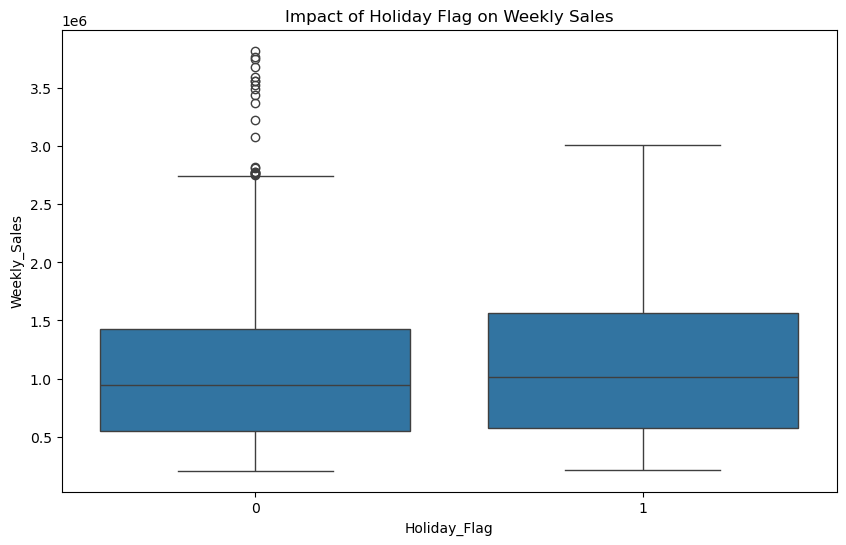

In [7]:
#holidays impact on sales
plt.figure(figsize=(10,6))
sns.boxplot(x='Holiday_Flag', y='Weekly_Sales', data=data_cleaned)
plt.title('Impact of Holiday Flag on Weekly Sales')
plt.show()


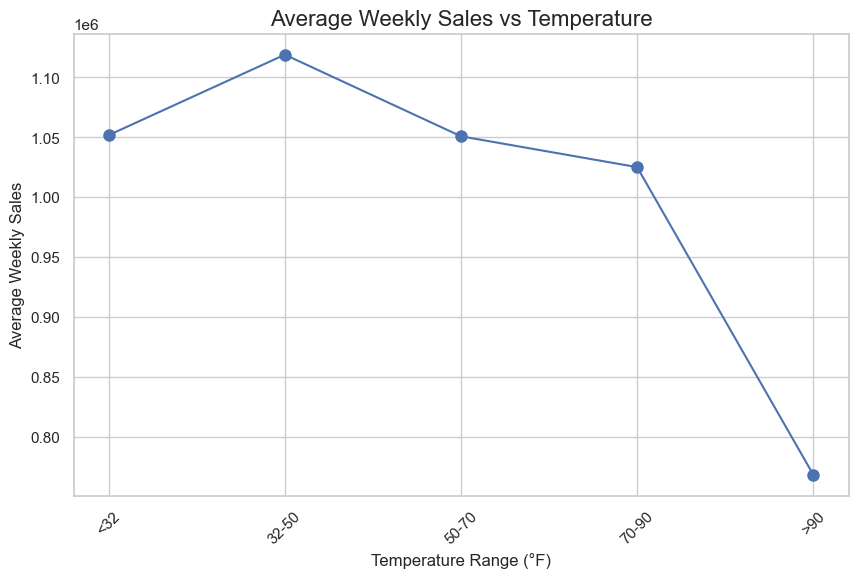

In [8]:
# sales over temperature
temperature_bins = [data_cleaned['Temperature'].min(), 32, 50, 70, 90, data_cleaned['Temperature'].max()]
temperature_labels = ['<32', '32-50', '50-70', '70-90', '>90']

data_cleaned['Temperature'] = pd.cut(data_cleaned['Temperature'], bins=temperature_bins, labels=temperature_labels)

# Group by temperature category and calculating average weekly sales
avg_sales_by_temp = data_cleaned.groupby('Temperature')['Weekly_Sales'].mean()
avg_sales_by_temp = avg_sales_by_temp.sort_index()
# Use seaborn to set a smooth style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(avg_sales_by_temp.index, avg_sales_by_temp.values, marker='o', linestyle='-', color='b', markersize=8)
plt.title('Average Weekly Sales vs Temperature', fontsize=16)
plt.xlabel('Temperature Range (°F)', fontsize=12)
plt.ylabel('Average Weekly Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()





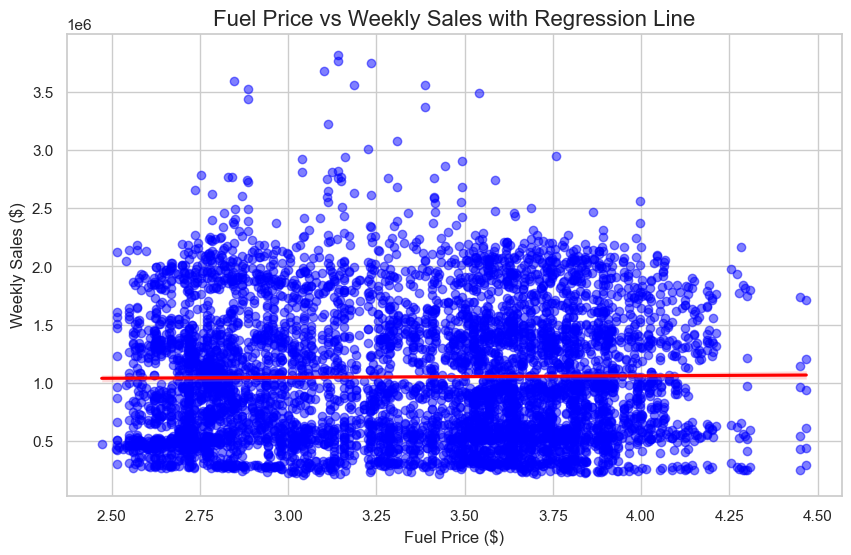

In [9]:



plt.figure(figsize=(10, 6))
sns.regplot(x='Fuel_Price', y='Weekly_Sales', data=data_cleaned, scatter_kws={'color': 'blue', 'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('Fuel Price vs Weekly Sales with Regression Line', fontsize=16)
plt.xlabel('Fuel Price ($)', fontsize=12)
plt.ylabel('Weekly Sales ($)', fontsize=12)
plt.show()




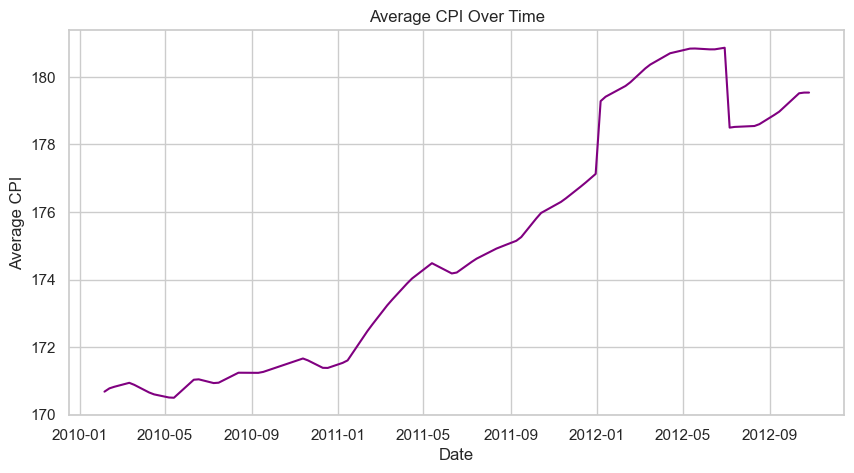

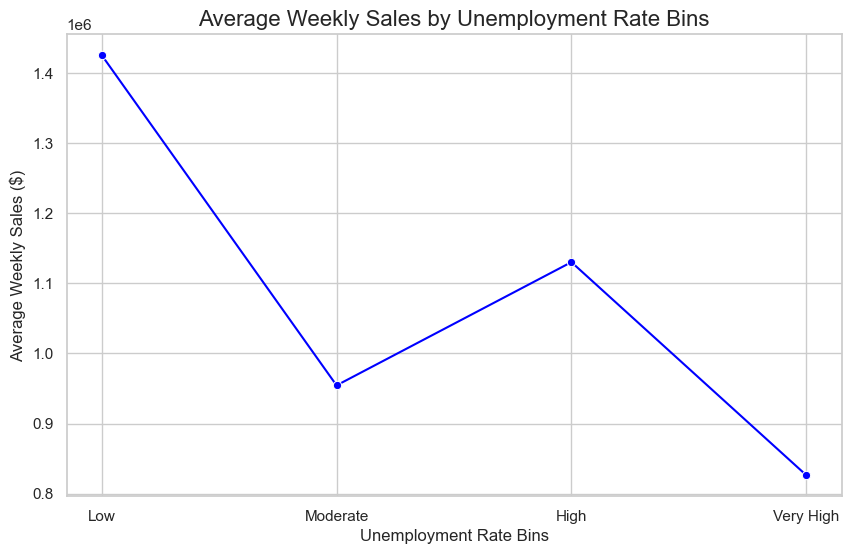

In [10]:

# Plot CPI
plt.figure(figsize=(10, 5))
plt.plot(aggregated_data.index, aggregated_data['CPI'], color='purple')
plt.title('Average CPI Over Time')
plt.xlabel('Date')
plt.ylabel('Average CPI')
plt.grid(True)
plt.show()


#creating bins for smoother sales vs temperature relation
bins = [0, 5, 7, 9, 12]  # bin ranges: Low, Moderate, High, Very High
labels = ['Low', 'Moderate', 'High', 'Very High']  # Label for each bin

#a new column for unemployment bins
data_cleaned['Unemployment_bin'] = pd.cut(data_cleaned['Unemployment'], bins=bins, labels=labels, right=False)
unemployment_sales_avg = data_cleaned.groupby('Unemployment_bin')['Weekly_Sales'].mean().reset_index()
sns.set(style="whitegrid")  
plt.figure(figsize=(10, 6))  
sns.lineplot(x='Unemployment_bin', y='Weekly_Sales', data=unemployment_sales_avg, marker='o', color='blue')
plt.title('Average Weekly Sales by Unemployment Rate Bins', fontsize=16)
plt.xlabel('Unemployment Rate Bins', fontsize=12)
plt.ylabel('Average Weekly Sales ($)', fontsize=12)
plt.show()







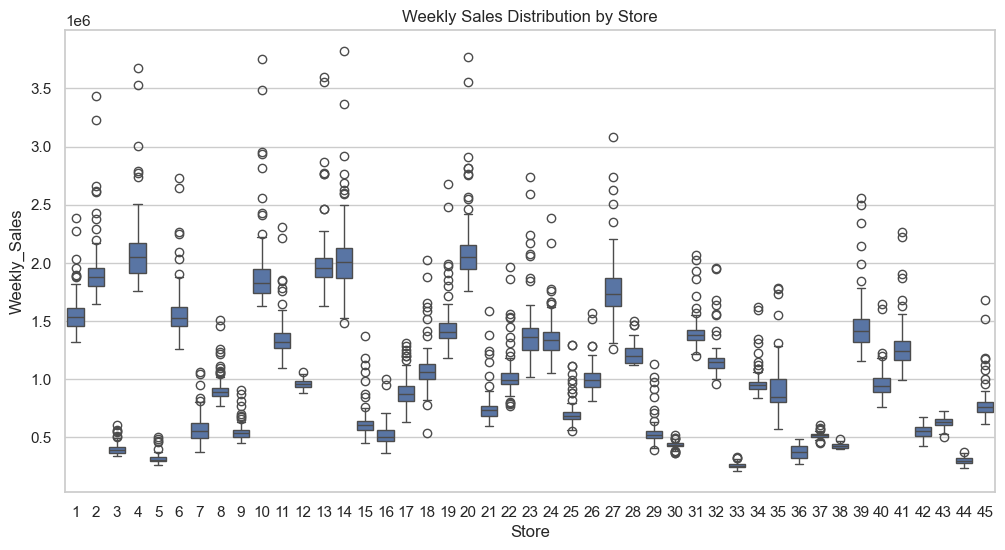

In [12]:
#stores sales
plt.figure(figsize=(12,6))
sns.boxplot(x='Store', y='Weekly_Sales', data=data_cleaned)
plt.title('Weekly Sales Distribution by Store')
plt.show()


In [14]:
#LINEAR REGRESSION MODEL

#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
#import pandas as pd
#import numpy as np

# Ensure no missing values or non-numeric data
X = data_cleaned[['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'day', 'month', 'year']]
y = data_cleaned['Weekly_Sales']

# Convert to numeric (if necessary) and handle missing values
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
y = pd.to_numeric(y, errors='coerce').fillna(0)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check shapes (for debugging)
print(X_train.shape, y_train.shape)

# Initializing and training the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Making predictions
y_pred = lr_model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

# Display the coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr_model.coef_})
print(coefficients)



(4763, 8) (4763,)
Mean Squared Error (MSE): 323085866660.81134
Mean Absolute Error (MAE): 481849.83285033505
R² Score: 0.009102043887370792
        Feature   Coefficient
0  Holiday_Flag  5.978401e+04
1   Temperature -2.346496e-10
2    Fuel_Price  9.035905e+04
3           CPI -1.360784e+03
4  Unemployment -4.999392e+04
5           day -1.255705e+03
6         month  1.336578e+04
7          year -6.328703e+04


In [15]:
#DECISION TREES
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize the model
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree = DecisionTreeRegressor(min_samples_split=10, min_samples_leaf=5, random_state=42)

# Train the model
tree.fit(X_train, y_train)

# Predict
y_pred_tree = tree.predict(X_test)
print("Decision Tree Results:")
print("MSE:", mean_squared_error(y_test, y_pred_tree))
print("MAE:", mean_absolute_error(y_test, y_pred_tree))
print("R²:", r2_score(y_test, y_pred_tree))



Decision Tree Results:
MSE: 308214463148.81696
MAE: 397114.47248895303
R²: 0.05471234401242053


In [16]:
#K Nearest Neighbors

# Import necessary libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Scaling the features for better working 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize K-Nearest Neighbors Regressor
knn = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors

# Fit the model
knn.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_knn = knn.predict(X_test_scaled)

# Print evaluation metrics
print("KNN Results:")
print("MSE:", mean_squared_error(y_test, y_pred_knn))
print("MAE:", mean_absolute_error(y_test, y_pred_knn))
print("R²:", r2_score(y_test, y_pred_knn))




KNN Results:
MSE: 362753423319.2433
MAE: 501011.9887506297
R²: -0.1125575669865635


In [17]:
#Random Forest 

from sklearn.ensemble import RandomForestRegressor

# Initializing Random Forest with some constraints
forest = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)

# Training the model
forest.fit(X_train, y_train)

# Predict
y_pred_forest = forest.predict(X_test)

# Evaluate
print("Random Forest Results:")
print("MSE:", mean_squared_error(y_test, y_pred_forest))
print("MAE:", mean_absolute_error(y_test, y_pred_forest))
print("R²:", r2_score(y_test, y_pred_forest))


Random Forest Results:
MSE: 245679870899.40585
MAE: 384789.29406518646
R²: 0.24650470028819638


In [18]:
#XGBoost
# Import necessary libraries
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# Initialize the XGBoost Regressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Fit the model on the training data
xgb_regressor.fit(X_train_scaled, y_train)

# Predict
y_pred_xgb = xgb_regressor.predict(X_test_scaled)

# Evaluate
print("XGBoost Results:")
print("MSE:", mean_squared_error(y_test, y_pred_xgb))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("R²:", r2_score(y_test, y_pred_xgb))




XGBoost Results:
MSE: 286105476350.5313
MAE: 382462.61788255675
R²: 0.1225201687760521


In [39]:
import pandas as pd

# Collect results
results = {
    "Model": ["Linear Regression", "Decision Tree", "KNN", "Random Forest", "XGBoost"],
    "MSE": [
        mean_squared_error(y_test, y_pred),
        mean_squared_error(y_test, y_pred_tree),
        mean_squared_error(y_test, y_pred_knn),
        mean_squared_error(y_test, y_pred_forest),
        mean_squared_error(y_test, y_pred_xgb),
    ],
    "MAE": [
        mean_absolute_error(y_test, y_pred),
        mean_absolute_error(y_test, y_pred_tree),
        mean_absolute_error(y_test, y_pred_knn),
        mean_absolute_error(y_test, y_pred_forest),
        mean_absolute_error(y_test, y_pred_xgb),
    ],
    "R²": [
        r2_score(y_test, y_pred),
        r2_score(y_test, y_pred_tree),
        r2_score(y_test, y_pred_knn),
        r2_score(y_test, y_pred_forest),
        r2_score(y_test, y_pred_xgb),
    ]
}

# Convert to DataFrame for better readability
results_df = pd.DataFrame(results)

# Display the summary
print(results_df)


               Model           MSE            MAE        R²
0  Linear Regression  3.230859e+11  481849.832850  0.009102
1      Decision Tree  3.082145e+11  397114.472489  0.054712
2                KNN  3.627534e+11  501011.988751 -0.112558
3      Random Forest  2.456799e+11  384789.294065  0.246505
4            XGBoost  2.861055e+11  382462.617883  0.122520
